In [1]:
import pandas as pd
import polars as pl
import numpy as np
import random
import DataSets_validation as ds
from sklearnex import patch_sklearn
patch_sklearn()
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import kaplanmeier as km
import warnings
from sklearn.metrics import RocCurveDisplay
import sys
import optuna
import pickle
warnings.filterwarnings("ignore")
random.seed(1024)
np.random.seed(1024)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/data/teamgdansk/mwaleron/miniconda3/envs/svn-opti/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def svm_train_test(train_data, train_y, test_data, classifier_params ={}, verbose=False):
    sm = SMOTE(random_state= 432)
    train_data, train_y = sm.fit_resample(train_data, train_y)
    clf = svm.SVC(kernel = classifier_params["kernel"],probability=True)
    clf = clf.fit(train_data, train_y)

    predictions = clf.predict(test_data)
    probs = clf.predict_proba(test_data)
    probSV = [i[1] for i in probs]
    if verbose:
        print(probSV)
    new_pd = pd.DataFrame(probSV)
    return clf, predictions, new_pd

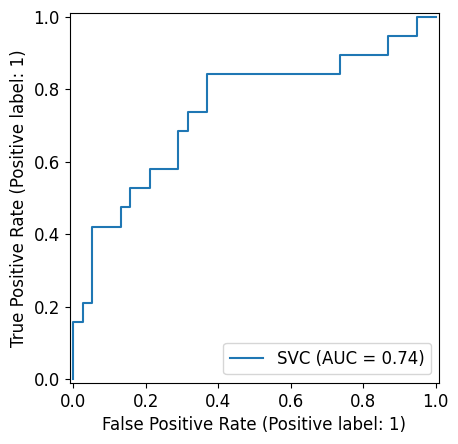

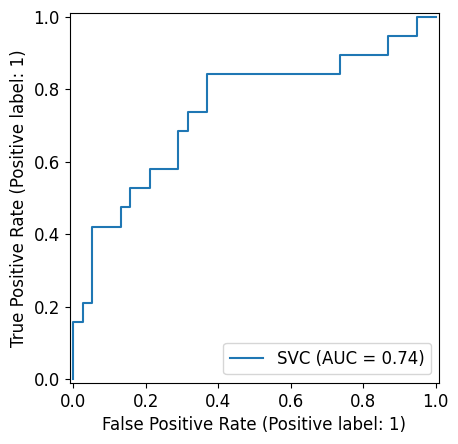

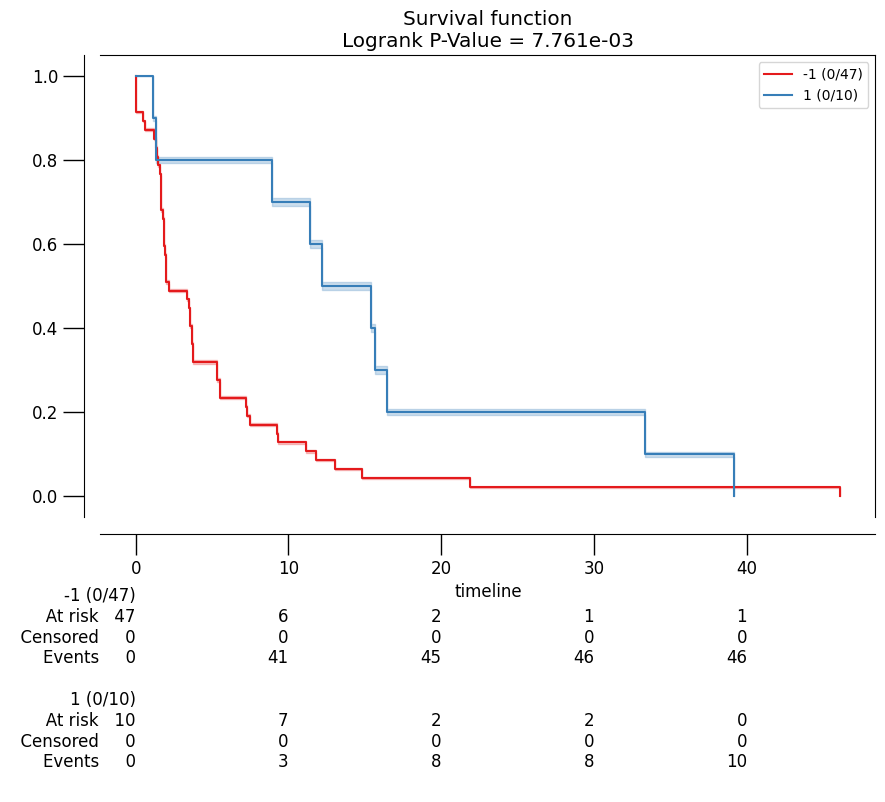

(<Figure size 1000x600 with 2 Axes>,
 <Axes: title={'center': 'Survival function\nLogrank P-Value = 7.761e-03'}, xlabel='timeline'>)

In [ ]:
weights = {"PS":1.0,
           "TF":0.1,
           "CF":0.1,
           "BP":0.5,
           "MT":0.5,
           "GE":0.5
           }
HS_features = ["Unique_peptides_narrow", "Promiscuity_narrow"]
additional_info = {
    "PRIMARY_TUMOR_ONLY":False,
    "with_mutations":True, 
    "random_contigs":False, 
    "hotspots":True, 
    "weights":weights, 
    "contig_file":"../data/braun_mutations_alternative_scoring_narrow_broad.tsv",
    "HS_features":HS_features
    }
train_data, train_y, test_data, test_y, test_pfs , excluded_mutation = ds.transforming_Braun_dataset(additional_info)
model,svm_linear_preds, svm_linear_prob = svm_train_test(train_data, train_y, test_data, {"kernel":"rbf"})

results1 = km.fit(test_pfs,test_y,svm_linear_preds)

rocsfigtest  = RocCurveDisplay.from_estimator(model, test_data, test_y)
rocsfigtest.plot()
km.plot(results1)

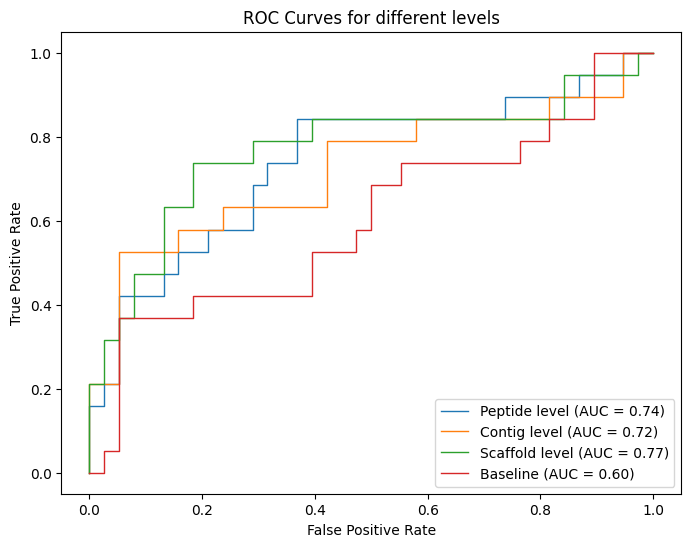

In [4]:
from sklearn.metrics import auc, roc_curve

configurations = [
    {
        "PRIMARY_TUMOR_ONLY": False,
        "with_mutations": True,
        "random_contigs": False,
        "hotspots": True,
        "weights": {"PS": 1.0, "TF": 0.1, "CF": 0.1, "BP": 0.5, "MT": 0.5, "GE": 0.5},
        "contig_file": "../data/braun_mutations_alternative_scoring_narrow_broad.tsv",
        "HS_features": ["Unique_peptides_narrow", "Promiscuity_narrow"],
        "plot_label": "Peptide level"
    },
    {
        "PRIMARY_TUMOR_ONLY": False,
        "with_mutations": True,
        "random_contigs": False,
        "hotspots": True,
        "weights": {"PS": 0.6, "TF": 0.6, "CF": 1.0, "BP": 0.1, "MT": 0.4, "GE": 0.0},
        "contig_file": "../data/Michal_combined_set_14_02_2025.tsv",
        "HS_features": ["unique_peptides", "popcov_but_sqrt"],
        "plot_label": "Contig level"
    },
    {
        "PRIMARY_TUMOR_ONLY": False,
        "with_mutations": True,
        "random_contigs": False,
        "hotspots": False,
        "weights": {"PS": 1.0, "TF": 0.1, "CF": 1.0, "BP": 0.4, "MT": 0.4, "GE": 0.3},
        "contig_file": "../data/Braun_hg38_epscaff10_w_score_2025.tsv",
        "HS_features": ["popcov_but_sqrt", "unique_peptides"],
        "plot_label": "Scaffold level"
    },
    {
        "PRIMARY_TUMOR_ONLY": False,
        "with_mutations": True,
        "random_contigs": False,
        "hotspots": False,
        "weights": {"PS": 0.8, "TF": 0.0, "CF": 0.5, "BP": 0.7, "MT": 0.8, "GE": 0.1},
        "contig_file": "../data/braun_mutations_alternative_scoring_narrow_broad.tsv",
        "HS_features": [],
        "plot_label": "Baseline"
    }
]

plt.figure(figsize=(8, 6))
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"
ax = plt.gca()

for config in configurations:
    train_data, train_y, test_data, test_y, test_pfs, _ = ds.transforming_Braun_dataset(config)
    model, _, svm_prob = svm_train_test(train_data, train_y, test_data, {"kernel": "rbf"})
    
    probs = svm_prob.values.flatten()
    
    fpr, tpr, _ = roc_curve(test_y, probs)
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, lw=1, alpha=1, 
            label=f'{config["plot_label"]} (AUC = {roc_auc:.2f})')
    
    with open(f"{config['plot_label'].replace(' ', '_')}.pkl", "wb") as f:
        pickle.dump(model, f)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves for different levels')
ax.legend(loc='lower right')
plt.savefig("ROC-curves.pdf")
plt.show()